In [1]:
# An example plotting script for DCMIP 2025 gravity wave break test case

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.colors as colors
import metpy.calc as mpc
import xarray as xr
from utils import *
import cftime
from math import floor, log10

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Parameters from the simulation:
small_earth_fact = 20.0
# mountain params
mtn_height = 4000
center_lon = np.deg2rad(72)
mtn_center_lat = np.deg2rad(45)
width_lon = np.deg2rad(7)
width_lat = np.deg2rad(40)
param_lon = width_lon / 2.0 * 1.0/(np.sqrt(-np.log(0.1)))
param_lat = width_lat / 2.0 * 1.0/(np.power(-np.log(0.1), 1.0/6.0))

In [4]:
def mountain_shape(lons):
    # height = np.zeros(np.shape(lons))
    height = mtn_height * np.exp(-np.square(lons-center_lon)/param_lon - np.power((np.deg2rad(lat_slice)-mtn_center_lat)/param_lat,6))
    return height

In [8]:
# Information about the paths
model = 'MPAS' # 'SE' or 'FV3' or 'MPAS'
vert = 'hydrostatic' # or 'nonhydrostatic'

# Name of your CAM clone:
CAM_dirname = 'CAM_6_4_060_06032025'

# Edit this to your own case name
case = 'dcmip2025_horiz_mount_flow_mpasa120'

# Modify the following according to your naming convention
nc_file = 'CAM_6_4_060_06032025.mpasa120_mpasa120.FHS94.mountain_gw.mpasa120_L207.cam.h0i.0001-01-01-21600.nc'

# Define the base root to the data, add your username
username = 'owhughes'
run_base = f'/glade/derecho/scratch/{username}/'
output_base = f'/glade/u/home/{username}/'

In [13]:
# Automatically set some paths
run_path = run_base + '/outputs/' + nc_file

In [15]:
ds = xr.open_dataset(run_path)

In [65]:
# specify desired plotting variables
field = 'rho' # modify this! options = 'U', 'V', T', 'div', 'vor'
# MPAS specific 'W', 'theta', 'rho'
t_idxs = [5, 10, 15] # which time indices to plot
lat_slice = 45
pt_cont = False # whether or not to plot potential temperature contours

In [56]:
ds

<xarray.Dataset> Size: 9GB
Dimensions:           (lat: 180, lon: 360, nbnd: 2, time: 20, lev: 207,
                       nCells: 40962, ilev: 208, trop_pref: 207, trop_prefi: 208)
Coordinates:
  * lat               (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon               (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * ilev              (ilev) float64 2kB 4.017e+04 3.997e+04 ... 100.0 0.0
  * lev               (lev) float64 2kB 4.007e+04 3.987e+04 ... 151.7 50.0
  * time              (time) object 160B 0001-01-01 06:00:00 ... 0001-01-06 0...
  * trop_pref         (trop_pref) float64 2kB 2.749 2.824 2.903 ... 982.2 994.1
  * trop_prefi        (trop_prefi) float64 2kB 2.711 2.786 2.863 ... 988.2 1e+03
Dimensions without coordinates: nbnd, nCells
Data variables: (12/42)
    lat_bnds          (lat, nbnd) float64 3kB ...
    lon_bnds          (lon, nbnd) float64 6kB ...
    gw                (lat) float64 1kB ...
    area              (lat, lon) float64 518kB ...
    OMEGA             (time, lev, lat, lon) float32 1GB ...
    OMEGA850          (time, lat, lon) float32 5MB ...
    ...                ...
    nsteph            (time) int32 80B ...
    rho               (time, lev, lat, lon) float32 1GB ...
    sol_tsi           (time) float64 160B ...
    theta             (time, lev, lat, lon) float32 1GB ...
    time_written      (time) |S8 160B ...
    w                 (time, ilev, lat, lon) float32 1GB ...
Attributes: (12/18)
    Conventions:                CF-1.0
    source:                     CAM
    case:                       CAM_6_4_060_06032025.mpasa120_mpasa120.FHS94....
    logname:                    owhughes
    host:                       dec2434
    initial_file:               /glade/derecho/scratch/owhughes/MPAS_GRIDS/L2...
    ...                         ...
    remap_script:               ncremap
    remap_hostname:             derecho5
    remap_version:              5.3.1
    title:                      Regridded version of ncol.nc
    map_file:                   /glade/u/home/owhughes/regrid/map_mpasa120_to...
    input_file:                 /glade/derecho/scratch/owhughes/outputs/nativ...

In [69]:
time_stamps = ds['time']
lats = ds['lat']
lons = ds['lon']
levs = ds['lev']
time_stamps_str = cftime.date2num(ds['time'].data, 'days since 0001-1-1')

print(f'There are {len(time_stamps)} time samples')
print(f'{len(lats)} latitiude points, {len(lons)} longitude points')

There are 20 time samples
180 latitiude points, 360 longitude points


In [70]:
# Crop to the subdomain of interest

lon_crop_left = 50.
lon_crop_right = 120.
lon_ticks = np.linspace(60, 110, 6) # Plotting ticks

if model != "MPAS":
    height_bot = 0
    height_top = 40000
    height_levs = np.linspace(height_bot, height_top, 51)
else:
    height_levs = levs

lon_inds = np.where((lons > lon_crop_left) & (lons < lon_crop_right))[0]

print(f'{len(lon_inds)} lon vals will be plotted')

lon_slice = lons[lon_inds] 
heights = mountain_shape(np.deg2rad(lon_slice))

70 lon vals will be plotted


In [71]:
if model == "MPAS":
    # already in height coordinates, no vertical interp needed
    if (field == "div" or field == "vor"):
        uv = ds[['U', 'V']].isel(time=t_idxs)
        if (field == "div"):
            vals = mpc.divergence(uv['U'], uv['V'])
        else:
            vals = mpc.vorticity(uv['U'], uv['V'])
        vals = vals.isel(lon=lon_inds).interp(lat=lat_slice)
    elif (field == "W"):
        vals = ds['w'].isel(time=t_idxs, lon=lon_inds).interp(lat=lat_slice, method='linear').interp(ilev=height_levs, method='linear')
    else:
        vals = ds[field].interp(lat=lat_slice, method='linear').isel(time=t_idxs, lon=lon_inds)
else:
    # interp from pressure to height coordiantes
    if field == 'div':
        z3 = ds['Z3'].isel(time=t_idxs).interp(lat=lat_slice).isel(lon=lon_inds)
        div = mpc.divergence(ds['U'].isel(time=t_idxs), ds['V'].isel(time=t_idxs)).interp(lat=lat_slice).isel(lon=lon_inds).to_dataset(name='div').assign(Z3=z3)
        vals = z_interp_divvor(div, t_idxs, height_levs, lon_inds)
    elif field == 'vor':
        z3 = ds['Z3'].isel(time=t_idxs).interp(lat=lat_slice).isel(lon=lon_inds)
        vor = mpc.vorticity(ds['U'].isel(time=t_idxs), ds['V'].isel(time=t_idxs)).interp(lat=lat_slice).isel(lon=lon_inds).to_dataset(name='vor').assign(Z3=z3)
        vals = z_interp_divvor(vor, t_idxs, height_levs, lon_inds)
    elif field == "W":
        # under construction
        vals = 0
    else:
        vals = z_interp_xr(ds[[field, 'Z3']].interp(lat=lat_slice, method='linear'), t_idxs, height_levs, lon_inds)

In [72]:
if pt_cont: # potential temperature contours
    if model == "MPAS":
        pt_interp = ds['theta'].isel(time=t_idxs, lon=lon_inds).interp(lat=lat_slice, method='linear')
    else:
        z3 = ds['Z3'].isel(time=t_idxs).interp(lat=lat_slice, method='linear').isel(lon=lon_inds)
        hyam = ds['hyam']
        hybm = ds['hybm']
        pressure = hyam*1e5 + hybm*ds['PS'].isel(time=t_idxs, lon=lon_inds).interp(lat=lat_slice, method='linear')
        mod_pres = np.power(1e5 / pressure, 0.286)
        pot_temp = ds['T'].isel(time=t_idxs, lon=lon_inds).interp(lat=lat_slice, method='linear') * mod_pres
        pt_interp = z_interp_divvor(pot_temp.to_dataset(name="potential temperature").assign(Z3=z3), t_idxs, height_levs, lon_inds)

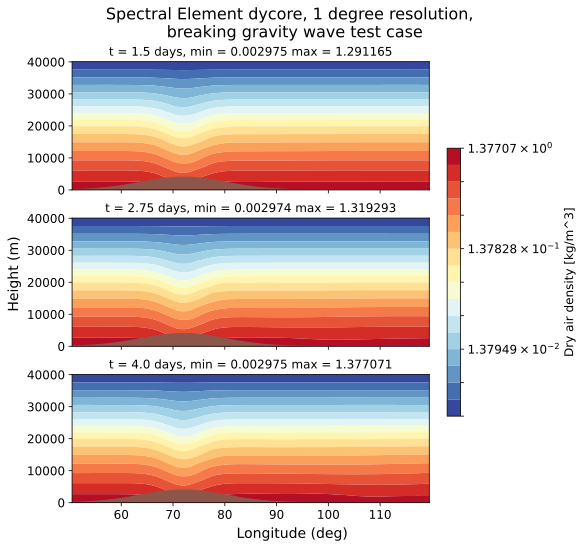

In [84]:
# make the plot
fig, axes = plt.subplots(len(t_idxs),1, figsize=(8.0,10.0*len(t_idxs)/4.0), sharex=True, layout='constrained')

title_size=16
label_size=14
small_size=12
round_dig = 2

fix_minmax = False

# Feel free to add additional fields
if field == 'T':
    title = 'Temperature'
    cb_label = '$T$ [K]'
    min = -2
    max = 5
elif field == 'U':
    title = 'Zonal velocity'
    cb_label = '$u$ [m/s]'
    min = -1.5
    max = 0.6
elif field == 'V':
    title = "Meridional velocity"
    cb_label = '$v$ [m/s]'
    min = -9
    max = 9
elif field == 'div':
    title = "Horizontal divergence"
    cb_label = '$\sigma$ [1/s]'
    round_dig = 6
elif field == "W":
    title = "Vertical velocity"
    cb_label = '$w$ [m/s]'
elif field == "theta":
    title = "Potential temperature"
    cb_label = '[K]'
elif field == "rho":
    title = "Dry air density"
    cb_label = '[kg/m^3]'
    round_dig = 6

# for the color map
valmin = np.nanmin(vals)
valmax = np.nanmax(vals)

if fix_minmax:
    levels = 17
    levels = np.mgrid[min:max:levels*1j]
else:
    levels = 17
    valmin = round(0.9*valmin, 1-int(floor(log10(abs(valmin)))))
    valmax = round(1.1*valmax, 1-int(floor(log10(abs(valmax)))))
    levels = np.mgrid[valmin:valmax:levels*1j]
    
if ((-1e-10 > valmin) and (1e-10 < valmax)):
    if fix_minmax:
        norm = MidpointNormalize(midpoint = 0, vmin = min, vmax = max)
    else:
        norm = MidpointNormalize(midpoint = 0, vmin = valmin, vmax = valmax)
    cmap_choice = 'RdBu_r'
elif (valmin < 1e-10):
    cmap_choice = "Blues"
    if (fix_minmax):
        norm = colors.Normalize(vmin=min, vmax=max)
    else:
        norm = colors.Normalize(vmin=0, vmax=valmax)       
else:
    if (fix_minmax):
        norm = colors.Normalize(vmin=min, vmax=max)
    elif field == "rho":
        norm = matplotlib.colors.LogNorm()
        valmin = np.nanmin(vals)
        valmax = np.nanmax(vals)
        # levels = np.mgrid[valmin:valmax:17j]
        levels = np.geomspace(valmin, valmax, num=17)
    else:
        norm = colors.Normalize(vmin=valmin, vmax=valmax)
    cmap_choice = 'RdYlBu_r'



for ind, ax in enumerate(np.ravel(axes)):
    if fix_minmax:
        plot = ax.contourf(lon_slice, height_levs, vals[ind], levels=levels, cmap=cmap_choice, norm=norm, extend='both')
    else:
        plot = ax.contourf(lon_slice, height_levs, vals[ind], levels=levels, cmap=cmap_choice, norm=norm)

    if pt_cont:
        ax.contour(lon_slice, height_levs, pt_interp[ind], colors='black')
    ax.tick_params(axis='both', labelsize=small_size)
    ax.set_ylim(0, np.max(height_levs))
    ax.set_title(f't = {time_stamps_str[t_idxs[ind]]} days, min = ' + '%.*f' % (round_dig, np.nanmin(vals[ind])) + ' max = ' + '%.*f' % (round_dig, np.nanmax(vals[ind])))
    ax.fill_between(lon_slice, heights, color='tab:brown', zorder=2)

cb = plt.colorbar(plot, ax=axes, fraction=0.05*len(t_idxs)/4.0)
cb.set_label(label=title + " " + cb_label, size=small_size)
cb.ax.tick_params(labelsize=small_size)

fig.supylabel('Height (m)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

fig.suptitle('Spectral Element dycore, 1 degree resolution, \n breaking gravity wave test case', size=title_size)

plt.show()